----

In [173]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from sklearn import preprocessing
from scipy import stats

from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.metrics import matthews_corrcoef
from sklearn import tree

In [146]:
# settings
np.seterr(divide='warn', invalid='warn'); sns.set_style("whitegrid");warnings.filterwarnings('ignore')

-----

# Project: Bosch Manufacturing Line

__Author:__ [Ryan Harper](www.kimrharper.com) <br><br>
__Data Source:__ [Bosch Dataset via Kaggle](https://www.kaggle.com/c/bosch-production-line-performance/data) <br> <br>
__Background:__ Bosch is a home appliance and industrial tools manufacturing company. In 2017, Bosch supplied Kaggle.com with manufacturing data to promote a competition. The goal of the competition was to determine factors that influence whether or not the product passes the final response stage of manufacturing and to predict which products are likely to fail based on this manufacturing process.<br> <br>
__The Data:__ Early exploration of this data will use a subset of the big data provided by Bosch. The data is provided by [Hitesh, John, and Matthew via PDX Data Science Meetup](https://www.meetup.com/Portland-Data-Science-Group/events/257370691/). The data subset is divided into 2 groups of 3 files (3 training, 3 test). Each group has one csv file each for numerical features ('numeric'), dates ('date'), and the manufacturing path ('cat'). The data subset includes a larger percentage of products that failed the response test, but not much more is known about this subsampling method.<br><br>
__Assumptions:__ ID # represents a specific product and that there is only one product. The differences in assembly are due to customization and/or differences between lines.<br><br>
__Goal:__ Predict which products will fail the response test. <br><br>

## III. Dimensionality Reduction

### A. Import Data

In [218]:
from sklearn.linear_model import LinearRegression, LogisticRegression

In [27]:
%%time
# import numerical data
mf_num_data = pd.read_csv('bosch_small_data/train_numeric.csv',low_memory=False)

CPU times: user 9.82 s, sys: 1.58 s, total: 11.4 s
Wall time: 11.7 s


### B. Split data to x,y

In [305]:
X = mf_num_data.iloc[:,1:-1]
features = list(X.columns)

impute_constant = SimpleImputer(missing_values=np.nan, strategy='constant',fill_value=-10)
X = impute_constant.fit_transform(X)
y = mf_num_data.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2, random_state=42)

### C. Declare Functions

In [250]:
def visualize_data(pipeline,dimred):
    feature_plot = list(zip(features, pipeline.named_steps[dimred].components_[0]))
    feature_plot = pd.DataFrame(data=feature_plot)
    feature_plot = pd.DataFrame(feature_plot.sort_values(1, ascending=False).iloc[0:10])
    plt.figure(figsize=(20,5))
    plt.title('Ordered by variance')
    sns.barplot(x=0, y=1, data=feature_plot, palette=sns.color_palette("cool"))
    plt.show()
    
    
    plt.figure(figsize=(20,8))
    plt.title('Component Variance')
    plt.plot(pipeline.named_steps[dimred].explained_variance_ratio_)

In [318]:
logr = LogisticRegression(random_state=42, solver='liblinear', multi_class='auto')

pipeline_tsvd = Pipeline([
    ('tsvd', TruncatedSVD(n_components=200)),
    ('lr', logr)
])

pipeline_pca = Pipeline([
    ('pca', PCA(n_components=200)),
    ('lr', logr)
])

pipeline_logr = Pipeline([
    ('lr', logr)
])

pipeline_tsvd.fit(X_train,y_train)
print('*')
pipeline_pca.fit(X_train,y_train)
print('*')
pipeline_logr.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=42, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False))])

In [319]:
prediction_tsvd = pipeline_tsvd.predict(X_test)
print(prediction_tsvd.sum())
prediction_pca = pipeline_pca.predict(X_test)
print(prediction_pca.sum())
prediction_lr = pipeline_logr.predict(X_test)
print(pipeline_logr.sum())
print('TSVD: {}\nPCA: {}\nLogR: {}'.format(matthews_corrcoef(test_y, prediction_tsvd), 
                                           matthews_corrcoef(test_y, prediction_pca),
                                           matthews_corrcoef(test_y, prediction_lr)))

ValueError: X has 200 features per sample; expecting 968

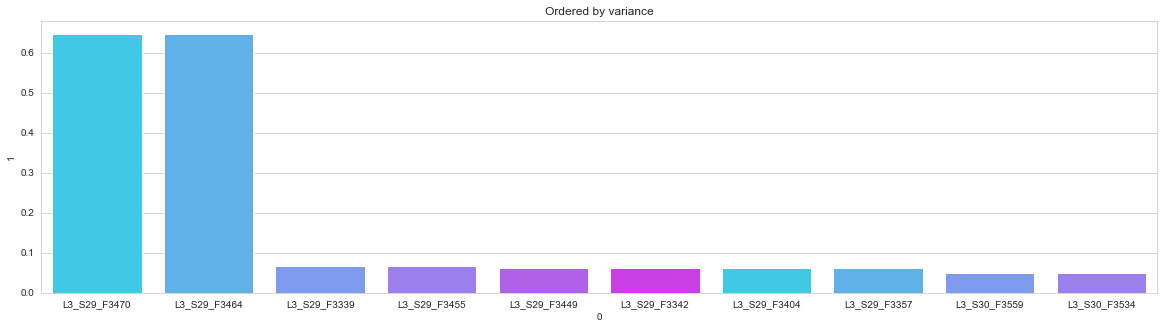

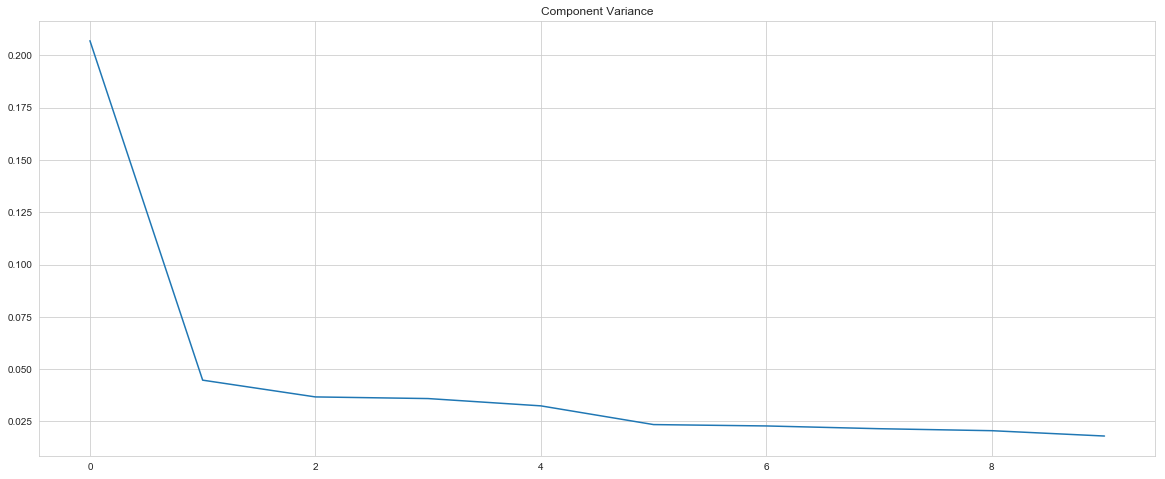

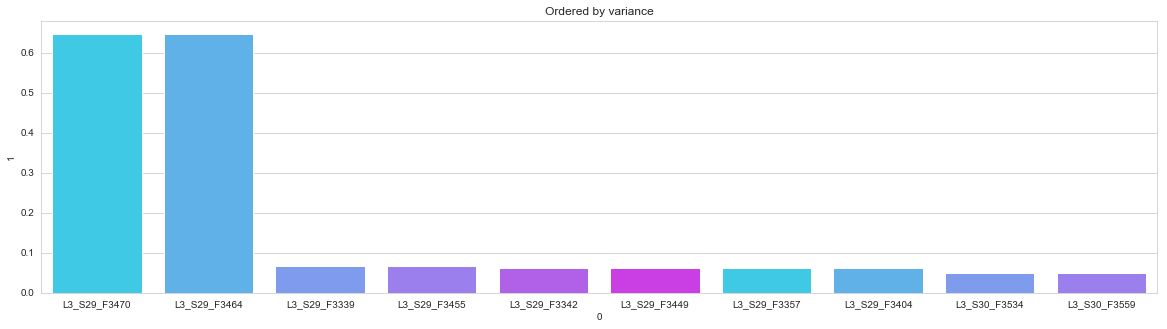

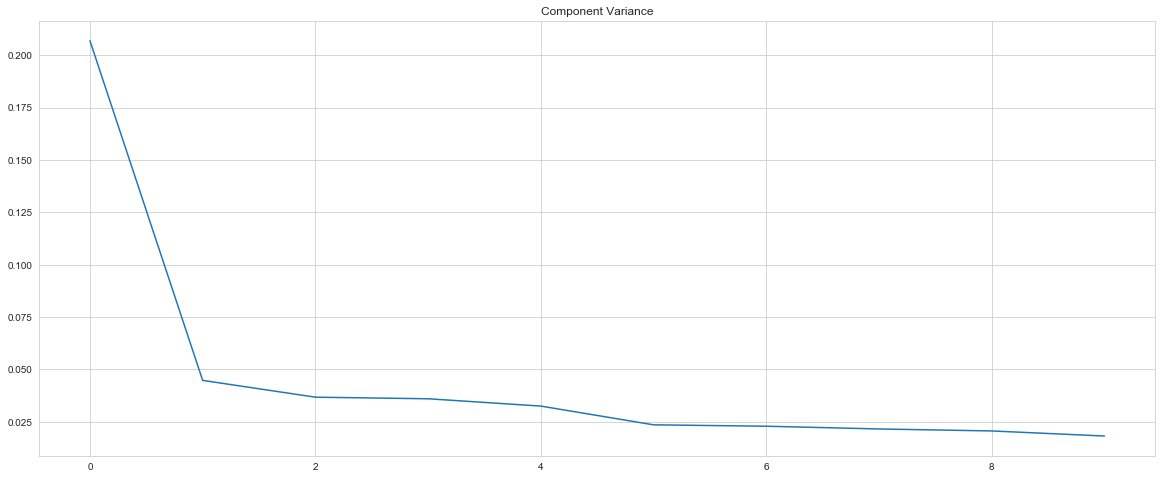

In [168]:
visualize_data(tsvd_model,'tsvd')
visualize_data(pca_model,'pca')

In [ ]:
matthews_corrcoef(y_true, y_pred) 